# Vacant Property Prediction and Pattern Analysis in Syracuse
**Group**: 2-8  
**Author**: Eric Lee, Ari Fazlija, Rajat Rohilla, RIshikesh Thakker   
**Date**: 12/13/2024  

# Objectives
- Understand factors contributing to building vacancies.
- Perform clustering to identify groups of similar properties.
- Build a predictive modeㅣ to estimate the likelihood of a property being vacant.

# Data Loading
In this section, we load the necessary datasets and inspect the basic information of each dataset, such as size, type, and structure. The datasets include:
- **Building Data**: Contains information about properties, such as address, year built, and location of buildings in Syracuse.
- **Code Violation Data**: Includes records of violations.
- **Crime Data**: Provides crime statistics for different areas.
- **Vacant Properties Data**: Lists known vacant properties with geolocation.


In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("VacancyPrediction") \
    .getOrCreate()

# Define paths relative to the current directory
code_violation_path = "./Code_Violations.csv"
building_data_path = "./All_Building_Data.csv"
vacant_properties_path = "./Vacant_Properties.csv"
crime_data_path = "./crime_summary1.csv"

# Import data
code_violation = spark.read.csv(code_violation_path, header=True, inferSchema=True)
building_data = spark.read.csv(building_data_path, header=True, inferSchema=True)
vacant_properties = spark.read.csv(vacant_properties_path, header=True, inferSchema=True) # for map
crime_data = spark.read.csv(crime_data_path, header=True, inferSchema=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
code_violation.printSchema()
code_violation.show(5)

building_data.printSchema()
building_data.show(5)

vacant_properties.printSchema()
vacant_properties.show(5)

crime_data.printSchema()
crime_data.show(5)

root
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)
 |-- violation_number: string (nullable = true)
 |-- complaint_address: string (nullable = true)
 |-- complaint_zip: integer (nullable = true)
 |-- SBL: string (nullable = true)
 |-- violation: string (nullable = true)
 |-- violation_date: string (nullable = true)
 |-- comply_by_date: string (nullable = true)
 |-- status_type_name: string (nullable = true)
 |-- complaint_number: string (nullable = true)
 |-- complaint_type_name: string (nullable = true)
 |-- open_date: string (nullable = true)
 |-- owner_name: string (nullable = true)
 |-- inspector_id: integer (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Vacant: string (nullable = true)
 |-- owner_address: string (nullable = true)
 |-- owner_city: string (nullable = true)
 |-- owner_state: string (nullable = true)
 |-- owner_zip_code: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |--

In [3]:
print("Code Violations:", code_violation.count())
print("Building Data:", building_data.count())
print("Vacant Properties:", vacant_properties.count())
print("Crime Data:", crime_data.count())

Code Violations: 137623
Building Data: 41096
Vacant Properties: 1335
Crime Data: 4974


# Data Cleaning & Preprocessing

In this section, we performed the necessary data cleaning and preprocessing steps to ensure the data is ready for analysis, focusing on the following steps:

- **Column Selection**: Based on the analysis of each dataset, we decided which columns to include in the EDA or modeling process. We excluded irrelevant or redundant columns that did not contribute to the analysis.

- **Frequency Analysis of Code Violations and Crimes**: For the **Code Violation** and **Crime Data**, we created new columns to capture the most frequent types of violations and crimes, along with the frequency of each occurrence.

- **Merging Datasets**: We merged the datasets using the **address** column as the common key. This ensured that all relevant information from the different datasets was combined into one comprehensive dataset.

- **Handling Null Values in the Merged Dataset**: After merging the datasets, we checked for any remaining null values and applied appropriate techniques, such as imputation or removal, to ensure the dataset was clean.

- **Extracting ZIP Code from Owner Address**: We created a new column that extracted the **ZIP code** from the owner address field for better data analysis.

- **Dropping Unnecessary Columns**: Finally, we removed any columns that were no longer needed or did not contribute to the analysis.

These steps ensure that the data is properly cleaned, merged, and prepared for further analysis, including clustering and regression.



In [4]:
from pyspark.sql.functions import col

# Checking null values in building data
null_counts = {}

for column in building_data.columns:
    null_count = building_data.filter(col(column).isNull()).count()
    null_counts[column] = null_count

for column, count in null_counts.items():
    if count > 0:
        print(f"{column}: {count} null values")

In [5]:
# Checking null values in code violation data
null_counts = {}

for column in code_violation.columns:
    null_count = code_violation.filter(col(column).isNull()).count()
    null_counts[column] = null_count

for column, count in null_counts.items():
    if count > 0:
        print(f"{column}: {count} null values")

X: 25 null values
Y: 25 null values
Neighborhood: 827 null values
Vacant: 120395 null values
owner_address: 849 null values
owner_city: 832 null values
owner_zip_code: 991 null values
Latitude: 25 null values
Longitude: 25 null values


In [6]:
# Checking null values in crime data
null_counts = {}

for column in crime_data.columns:
    null_count = crime_data.filter(col(column).isNull()).count()
    null_counts[column] = null_count

for column, count in null_counts.items():
    if count > 0:
        print(f"{column}: {count} null values")

Column Selection

In [7]:
# Remove duplicate or inaccurate columns, retaining only data that is relevant and potentially useful for analysis.

from pyspark.sql.functions import upper, col

building_data_filtered = building_data.select(
    "FullAddres",  # Address(key)
    "Add4_OwnCi",  # owner city
    "Zip",  # zip code
    "n_ResUnits",  # Number of residential units
    "LUC_parcel", #categorizing the property by use
    "LU_parcel", # property type classification
    'land_av', #	Land assessed value
    'total_av', # Full assessed value
    'ACRES',  # Number of acres,
    "FRONT", # Front footage for square or rectangular shaped lots
    "DEPTH",# Actual depth of rectangular shaped lots in feet
    "yr_built", # Year built
    'DPW_Quad', # #Southwest, and Southeast based on property location
    'NHOOD', #  City Neighborhood
    'InPD', # Is property located in preservation district
    'ELECT_DIST', # Election district number
    "RNI", # Is property located in Resurgent Neighborhood Initiative (RNI) Area?
    "Shape__Area",
    "Shape__Length",
    "IPSVacant"  # vacant or not
)

code_violation_filtered = code_violation.select(
    "complaint_address",  # address(key)
    "violation",  # violation type
    "status_type_name",  # Status of the violation
    "Neighborhood", # Neighborhood where the "complaint_address" is located
    "Latitude",
    "Longitude",
    "complaint_zip"
)

crime_data_filtered = crime_data.select(
    "clean_address", # preprocessed address
    "crime_count",
    "most_frequent_crime"
)

vacant_properties_filtered = vacant_properties.select(
    'PropertyAddress',
    'Latitude',
    'Longitude'
)

# Make all the address upper class to merge the data
code_violation_filtered = code_violation_filtered.withColumn("violation_clean_address", upper(col("complaint_address")))
building_data_filtered = building_data_filtered.withColumn("building_clean_address", upper(col("FullAddres")))

Frequency Analysis of Code Violations and Crimes

In [8]:
from pyspark.sql.functions import count, expr, first

# Calculating Total Violation Counts and Most Frequent Violation Type
violation_summary = code_violation_filtered.groupBy("violation_clean_address", "Neighborhood").agg(
    count("violation").alias("total_violations"),
    expr("mode(violation)").alias("most_frequent_violation")
)


violation_summary.show(10)

+-----------------------+--------------------+----------------+-----------------------+
|violation_clean_address|        Neighborhood|total_violations|most_frequent_violation|
+-----------------------+--------------------+----------------+-----------------------+
|       1 DESTINY USA DR|                NULL|               1|   2015 IMPC - 605.1...|
|         100 ALANSON RD|          Strathmore|               1|   2020 PMCNYS - Sec...|
|   100 ARSENAL DR & ...|        South Valley|               6|   SPCC - Section 27...|
|          100 BELLE AVE|            Brighton|               2|   2020 PMCNYS - Sec...|
|   100 BERKELEY DR &...|University Neighb...|               1|   SPCC - Section 27...|
|   100 BRADFORD PKWY...|         Meadowbrook|               1|   SPCC - Section 27...|
|   100 BRISTOL PL & ...|            Westcott|               1|   SPCC - Section 27...|
|          100 BRONX AVE|      Court-Woodlawn|               7|   2020 PMCNYS - Sec...|
|      100 BUNGALOW TERR|       

Merging Datasets

In [9]:
# merge all building with code violation
final_building_data = building_data_filtered.join(
    violation_summary,
    building_data_filtered["building_clean_address"] == violation_summary["violation_clean_address"],
    "left"
).drop("violation_clean_address")

In [10]:
# merge all building with crime
# crime data does not contain full address. Therefore  I need to merge it with simialr data
from pyspark.sql.functions import col, regexp_replace, trim


# Comparing addresses without first numbers
final_building_data = final_building_data.withColumn(
    "matching_address",
    regexp_replace(col("building_clean_address"), r"^\d+\s", "")
)

# merge with matching_address
final_building_data = final_building_data.join(
    crime_data,
    final_building_data["matching_address"] == crime_data["clean_address"],
    "left"
).drop("matching_address")


In [11]:
final_building_data.show(5)

+--------------------+--------------------+-----+----------+----------+-------------+-------+--------+-----+-----+-----+--------+---------+---------+----+----------+---+----------------+----------------+---------+----------------------+------------+----------------+-----------------------+----------------+-----------+-------------------+
|          FullAddres|          Add4_OwnCi|  Zip|n_ResUnits|LUC_parcel|    LU_parcel|land_av|total_av|ACRES|FRONT|DEPTH|yr_built| DPW_Quad|    NHOOD|InPD|ELECT_DIST|RNI|     Shape__Area|   Shape__Length|IPSVacant|building_clean_address|Neighborhood|total_violations|most_frequent_violation|   clean_address|crime_count|most_frequent_crime|
+--------------------+--------------------+-----+----------+----------+-------------+-------+--------+-----+-----+-----+--------+---------+---------+----+----------+---+----------------+----------------+---------+----------------------+------------+----------------+-----------------------+----------------+-----------+-

Handling Null Values in the Merged Dataset

In [12]:
# Checking null values
null_counts = {}

for column in final_building_data.columns:
    null_count = final_building_data.filter(col(column).isNull()).count()
    null_counts[column] = null_count

for column, count in null_counts.items():
    if count > 0:
        print(f"{column}: {count} null values")

Neighborhood: 25351 null values
total_violations: 25289 null values
most_frequent_violation: 25289 null values
clean_address: 20369 null values
crime_count: 20369 null values
most_frequent_crime: 20369 null values


In [13]:
# Filling null values
final_building_data = final_building_data.fillna({
    "crime_count": 0,
    "most_frequent_crime": "No crime",
    "total_violations": 0,
    "most_frequent_violation": "No Violation",
    "Neighborhood": "Unknown"
})



In [14]:
# Vacant data preprocessing
from pyspark.sql.functions import trim, length

# Remove whitespace
final_building_data = final_building_data.withColumn("IPSVacant", trim(col("IPSVacant")))

from pyspark.sql.functions import when

# Converting ㄷmpty Strings to Null
final_building_data = final_building_data.withColumn(
    "IPSVacant", when(col("IPSVacant") == "", None).otherwise(col("IPSVacant"))
) # The vacant buildings are represented as empty fields instead of null

final_building_data.select("IPSVacant").show(5)


+---------+
|IPSVacant|
+---------+
|     NULL|
|     NULL|
|     NULL|
|     NULL|
|     NULL|
+---------+
only showing top 5 rows



In [15]:
#Filling IPSVacant null value
final_building_data = final_building_data.fillna({
    "IPSVacant": "Not Vacant"
})

In [16]:
# Converting IPSVacant values to 0 (Not Vacant) or 1 (Vacant)
final_building_data = final_building_data.withColumn(
    "is_vacant",  # New column
    when(col("IPSVacant") == "Not Vacant", 0).otherwise(1)  # Not Vacant = 0, others = 1
)

final_building_data.show(5)

+--------------------+--------------------+-----+----------+----------+-------------+-------+--------+-----+-----+-----+--------+---------+---------+----+----------+---+----------------+----------------+----------+----------------------+------------+----------------+-----------------------+----------------+-----------+-------------------+---------+
|          FullAddres|          Add4_OwnCi|  Zip|n_ResUnits|LUC_parcel|    LU_parcel|land_av|total_av|ACRES|FRONT|DEPTH|yr_built| DPW_Quad|    NHOOD|InPD|ELECT_DIST|RNI|     Shape__Area|   Shape__Length| IPSVacant|building_clean_address|Neighborhood|total_violations|most_frequent_violation|   clean_address|crime_count|most_frequent_crime|is_vacant|
+--------------------+--------------------+-----+----------+----------+-------------+-------+--------+-----+-----+-----+--------+---------+---------+----+----------+---+----------------+----------------+----------+----------------------+------------+----------------+-----------------------+-------

Extracting ZIP Code from Owner Address

In [17]:
# Owner address - to just zip code
from pyspark.sql.functions import regexp_extract

# Extracting Numbers (Zip Codes)
final_building_data = final_building_data.withColumn(
    "owner_zipcode",
    regexp_extract(col("Add4_OwnCi"), r"(\d{5})", 0)  # Extract 5-digit numbers for zipcode
)


final_building_data.select("Add4_OwnCi", "owner_zipcode").show(5)

+--------------------+-------------+
|          Add4_OwnCi|owner_zipcode|
+--------------------+-------------+
|   SYRACUSE NY 13204|        13204|
|JACKSONVILLE FL 3...|        32202|
|  CLEVELAND OH 44122|        44122|
|FAYETTEVILLE NY 1...|        13066|
|   SYRACUSE NY 13208|        13208|
+--------------------+-------------+
only showing top 5 rows



Dropping Unnecessary Columns

In [18]:
# Removing duplicate addresses
final_building_data = final_building_data.drop("Add4_OwnCi","FullAddres", "violation_clean_address", "clean_address", "original_address" )

final_building_data.show(5)


+-----+----------+----------+-------------+-------+--------+-----+-----+-----+--------+---------+---------+----+----------+---+----------------+----------------+----------+----------------------+------------+----------------+-----------------------+-----------+-------------------+---------+-------------+
|  Zip|n_ResUnits|LUC_parcel|    LU_parcel|land_av|total_av|ACRES|FRONT|DEPTH|yr_built| DPW_Quad|    NHOOD|InPD|ELECT_DIST|RNI|     Shape__Area|   Shape__Length| IPSVacant|building_clean_address|Neighborhood|total_violations|most_frequent_violation|crime_count|most_frequent_crime|is_vacant|owner_zipcode|
+-----+----------+----------+-------------+-------+--------+-----+-----+-----+--------+---------+---------+----+----------+---+----------------+----------------+----------+----------------------+------------+----------------+-----------------------+-----------+-------------------+---------+-------------+
|13208|         0|       330|  Vacant comm|  10000|   10000|  0.0|  0.0|  0.0|    

In [19]:
final_building_data.groupBy("is_vacant").count().show()

+---------+-----+
|is_vacant|count|
+---------+-----+
|        1| 1344|
|        0|39753|
+---------+-----+



# Exploratory Data Analysis (EDA)

### Key Steps

- Descriptive Statistics for numerical and categorical features
- Visualize the distribution of property values.
- Map the geographical distribution of vacant properties.


Descriptive Statistics Analysis

In [20]:
# Basic statistics of numerical variables
numerical_columns = ["land_av", "total_av","FRONT", "DEPTH", "ACRES", "Shape__Area" , "Shape__Length","total_violations","crime_count"]
final_building_data.describe(["land_av", "total_av","FRONT", "DEPTH", "ACRES", "Shape__Area" , "Shape__Length","total_violations","crime_count"]).show()

+-------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|          land_av|         total_av|            FRONT|             DEPTH|             ACRES|       Shape__Area|     Shape__Length|  total_violations|       crime_count|
+-------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|            41097|            41097|            41097|             41097|             41097|             41097|             41097|             41097|             41097|
|   mean|33295.10828040976|205348.8983380782|58.09721853176632|129.14904567243354|1.4865454899383972|13593.591992764628|419.91909077707476| 3.325425213519235|19.680244300070566|
| stddev|312818.1048386325|3268467.607196714|70.72219425590266|101.97559381246072|141.64391562137266| 93009.75

In [21]:
categorical_columns = ["Zip","owner_zipcode","n_ResUnits","LUC_parcel", "LU_parcel", "DPW_Quad", "NHOOD", "InPD", "ELECT_DIST", "IPSVacant","most_frequent_violation","most_frequent_crime"]

# value distribution by categorical variables
for col_name in categorical_columns:
    print(f"Value Counts for {col_name}:")
    final_building_data.filter(col("is_vacant") == 1).groupBy(col_name).count().orderBy("count", ascending=False).show(10)

Value Counts for Zip:
+-----+-----+
|  Zip|count|
+-----+-----+
|13205|  449|
|13204|  301|
|13208|  181|
|13203|  151|
|13207|   74|
|13206|   68|
|13210|   55|
|13224|   42|
|13202|   18|
|13214|    3|
+-----+-----+
only showing top 10 rows

Value Counts for owner_zipcode:
+-------------+-----+
|owner_zipcode|count|
+-------------+-----+
|        13205|  366|
|        13204|  107|
|        13208|   93|
|        13207|   90|
|        13203|   65|
|        13206|   63|
|        13210|   41|
|        13224|   32|
|        13214|   28|
|        13057|   28|
+-------------+-----+
only showing top 10 rows

Value Counts for n_ResUnits:
+----------+-----+
|n_ResUnits|count|
+----------+-----+
|         1|  673|
|         2|  332|
|         0|  199|
|         3|   63|
|         4|   45|
|         5|   15|
|         6|    5|
|        12|    2|
|        11|    2|
|       120|    1|
+----------+-----+
only showing top 10 rows

Value Counts for LUC_parcel:
+----------+-----+
|LUC_parcel|count|
+-

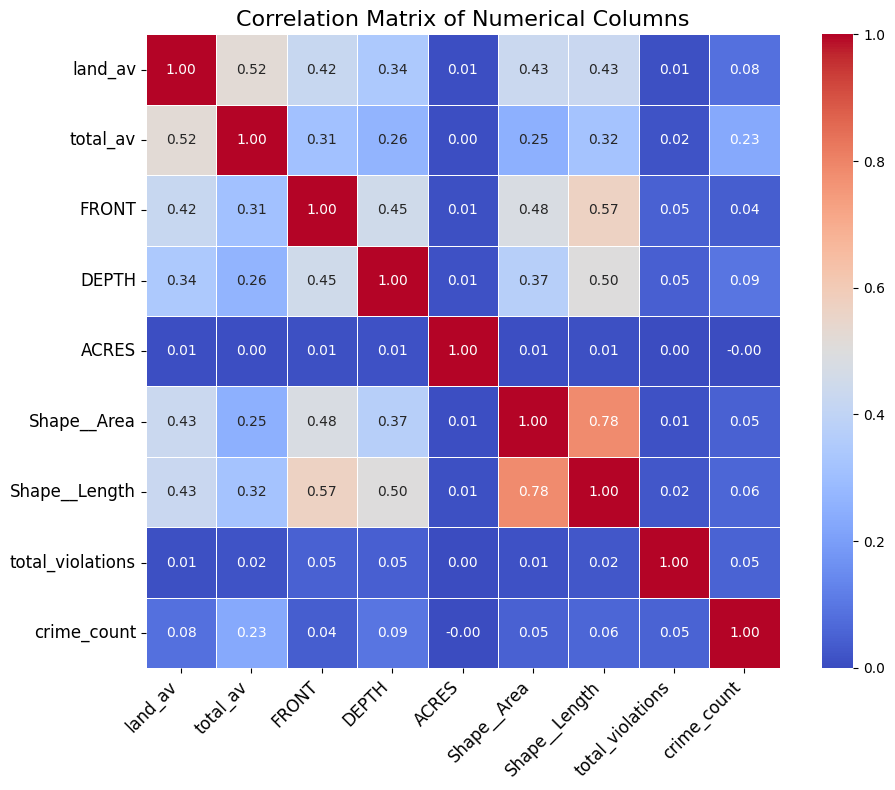

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert PySpark dataframe to Pandas for visualization
numerical_data = final_building_data.select(numerical_columns).toPandas()

# Calculate correlation matrix
correlation_matrix = numerical_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True, linewidths=0.5)
plt.title("Correlation Matrix of Numerical Columns", fontsize=16)
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# space related variables are related to each other especially Shape_Area and Shape_Length

In [26]:
# map visualization for vacant property status in Syracuse

vacant_properties_pd = vacant_properties_filtered.select("Latitude", "Longitude").toPandas()
vacant_properties_pd = vacant_properties_pd.dropna()


print(vacant_properties_pd.head())

   Latitude  Longitude
0   43.0243   -76.1490
1   43.0228   -76.1531
2   43.0246   -76.1567
3   43.0247   -76.1615
4   43.0289   -76.1431


In [27]:
vacant_properties_pd.count()

,0
Latitude,1307
Longitude,1307


In [28]:
null_counts = vacant_properties_pd.isnull().sum()

null_counts

,0
Latitude,0
Longitude,0


In [29]:
import folium
from folium.plugins import HeatMap, MarkerCluster

# geographic center coordinates of Syracuse
syracuse_center = [43.0481, -76.1474]

# Creating map
mymap = folium.Map(location=syracuse_center, zoom_start=12)

# add long, lat for map
heat_data = vacant_properties_pd[["Latitude", "Longitude"]].values.tolist()
HeatMap(heat_data).add_to(mymap)

# Adding Clustering
marker_cluster = MarkerCluster().add_to(mymap)
for _, row in vacant_properties_pd.iterrows():
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=f"Lat: {row['Latitude']}, Lon: {row['Longitude']}"
    ).add_to(marker_cluster)

mymap

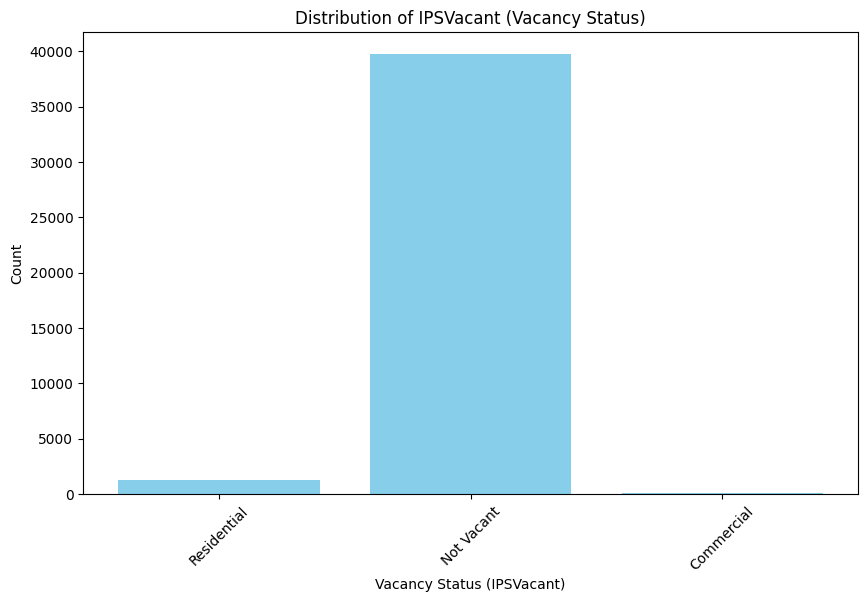

In [30]:
# Calculating Vacancy Status Distribution
vacancy_distribution = final_building_data.groupBy("IPSVacant").count().toPandas()


plt.figure(figsize=(10, 6))
plt.bar(vacancy_distribution['IPSVacant'], vacancy_distribution['count'], color='skyblue')
plt.xlabel('Vacancy Status (IPSVacant)')
plt.ylabel('Count')
plt.title('Distribution of IPSVacant (Vacancy Status)')
plt.xticks(rotation=45)
plt.show()

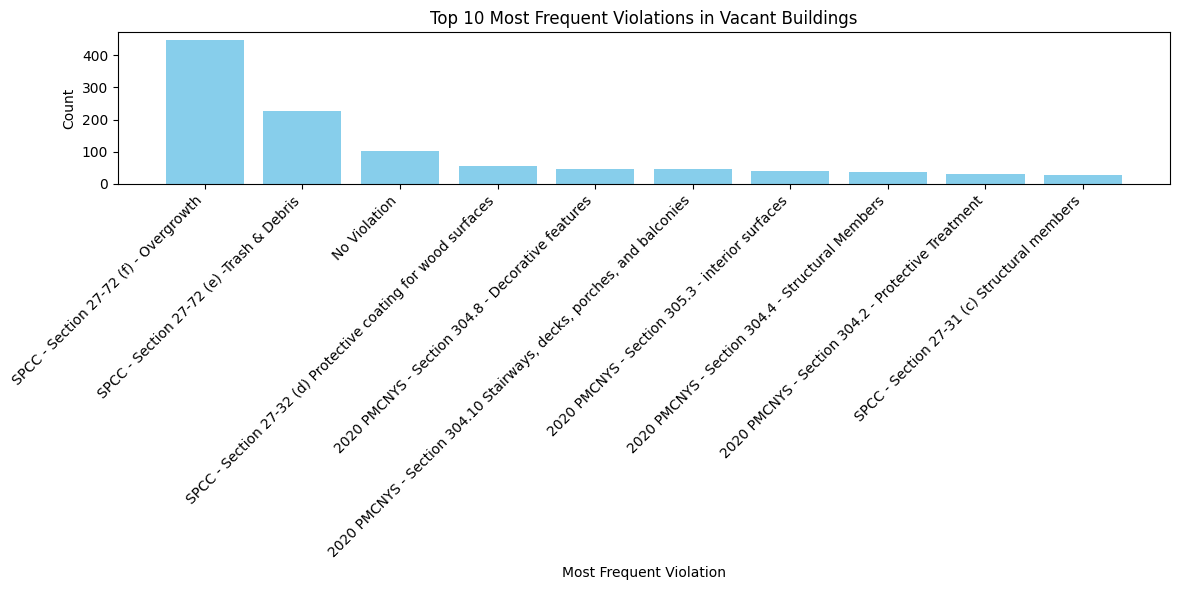

In [31]:
# Vacant buildings are neglected, leading to overgrowth and an accumulation of trash

from pyspark.sql.functions import col

# Filtering Only Vacant Buildings
vacant_buildings = final_building_data.filter(col("IPSVacant") != "Not Vacant")

# Calculating Frequency by most_frequent_violation
violation_counts = vacant_buildings.groupBy("most_frequent_violation").count().orderBy(col("count").desc()).toPandas()

top_violations = violation_counts.head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_violations["most_frequent_violation"], top_violations["count"], color="skyblue")
plt.xlabel("Most Frequent Violation")
plt.ylabel("Count")
plt.title("Top 10 Most Frequent Violations in Vacant Buildings")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

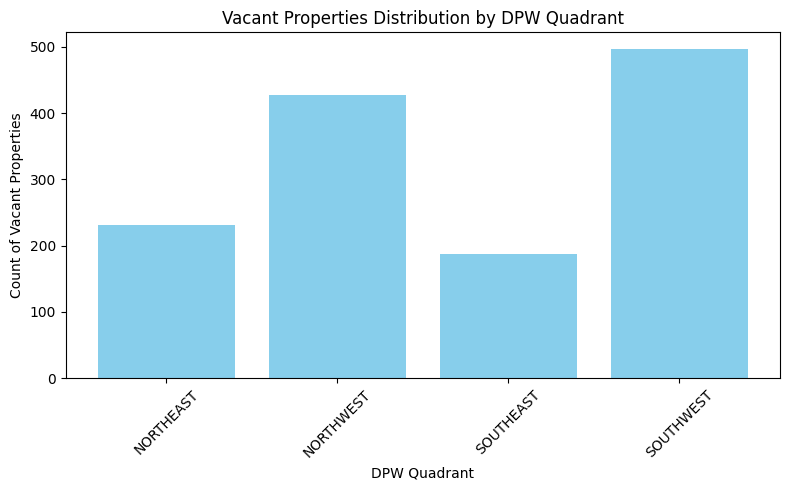

In [32]:
# Vacant Property Based on region

# Excluding 'Not Vacant' Values
vacant_buildings = final_building_data.filter(col("IPSVacant") != "Not Vacant")

# Calculating and Sorting Vacancies by DPW_Quad
quad_vacancy = (
    vacant_buildings.groupBy("DPW_Quad").count()
    .orderBy("DPW_Quad")
    .toPandas()
)


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(quad_vacancy["DPW_Quad"], quad_vacancy["count"], color="skyblue")
plt.xlabel("DPW Quadrant")
plt.ylabel("Count of Vacant Properties")
plt.title("Vacant Properties Distribution by DPW Quadrant")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# We can see that more than half of the vacancy are concentrated in the Northwest and Southwest areas.

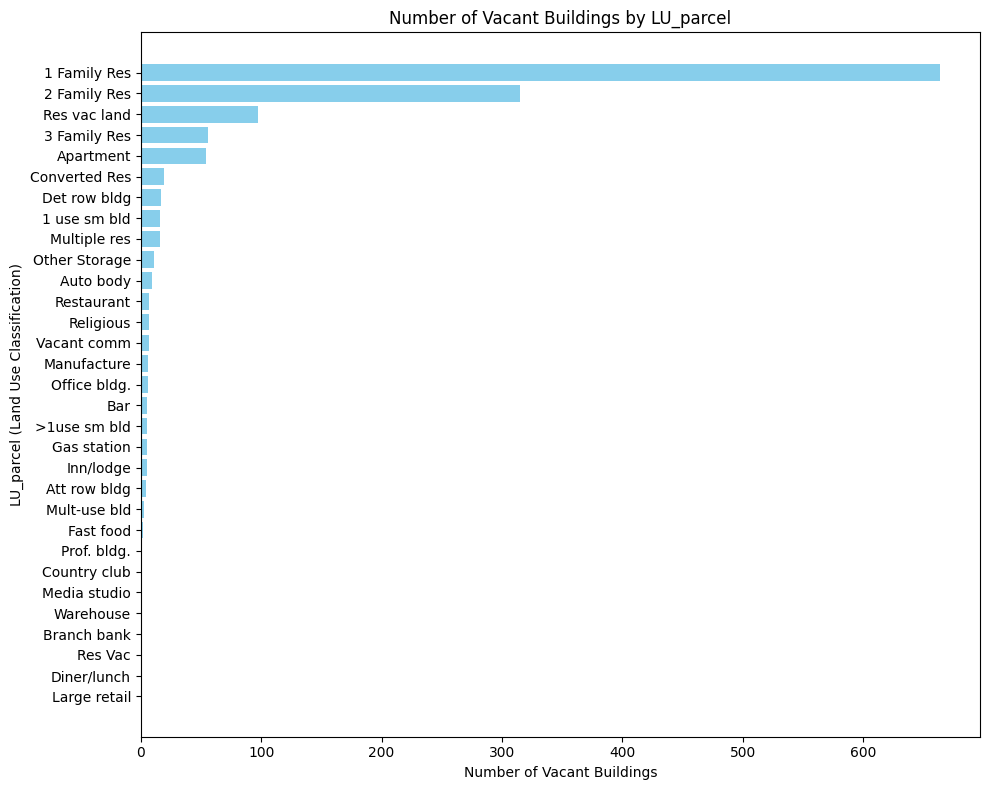

In [33]:
# Calculating Vacancy Status Data by LU_parcel
vacant_lu_distribution = vacant_buildings.groupBy("LU_parcel").count().toPandas()

# Calculating Total Vacancy Data by LU_parcel
total_vacant_by_lu = vacant_buildings.groupBy("LU_parcel").count().toPandas()

# Order data by LU_parcel
vacant_lu_distribution = vacant_lu_distribution.sort_values(by="count", ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(vacant_lu_distribution["LU_parcel"], vacant_lu_distribution["count"], color="skyblue")
plt.xlabel("Number of Vacant Buildings")
plt.ylabel("LU_parcel (Land Use Classification)")
plt.title("Number of Vacant Buildings by LU_parcel")
plt.tight_layout()
plt.show()

# It is evident that there are significantly more vacancies in residential areas.

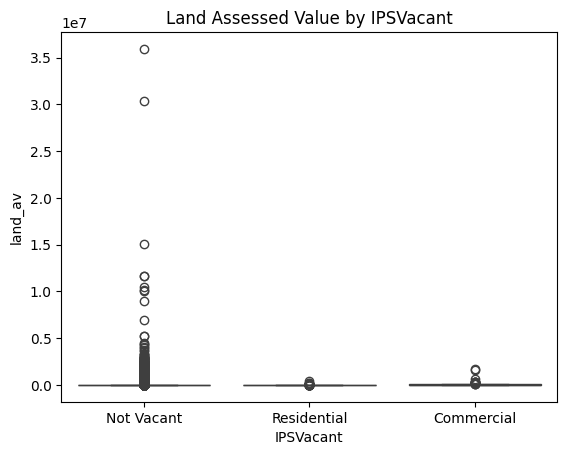

In [34]:
import seaborn as sns

#Land value comparison
land_av_vacant = final_building_data.select("land_av", "IPSVacant").toPandas()
sns.boxplot(x="IPSVacant", y="land_av", data=land_av_vacant)
plt.title("Land Assessed Value by IPSVacant")
plt.show()

<ipython-input-35-05f71beaa474>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_pd, x="is_vacant", y="Shape__Area", palette="Set2")


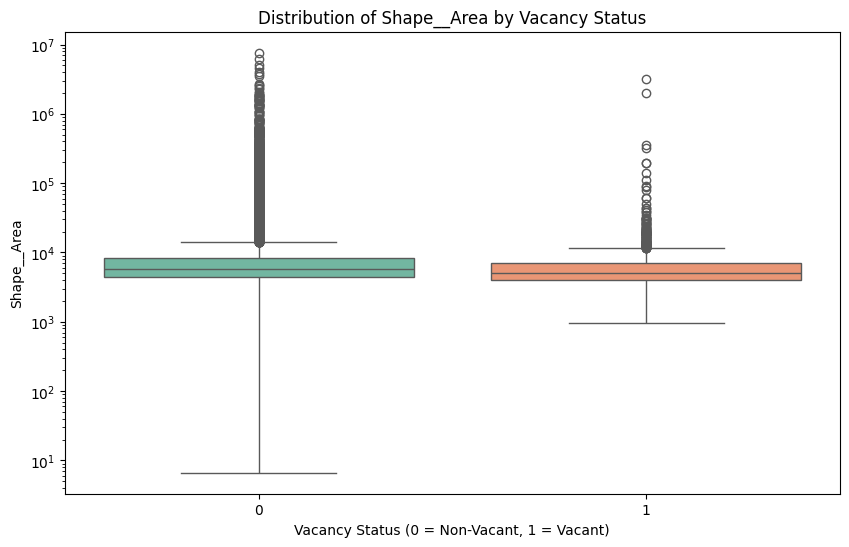

In [35]:

# Convert Spark DataFrame to Pandas for visualization
data_pd = final_building_data.select("Shape__Area", "is_vacant").toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_pd, x="is_vacant", y="Shape__Area", palette="Set2")
plt.title("Distribution of Shape__Area by Vacancy Status")
plt.xlabel("Vacancy Status (0 = Non-Vacant, 1 = Vacant)")
plt.ylabel("Shape__Area")
plt.yscale("log")  # Use log scale if there are large outliers
plt.show()

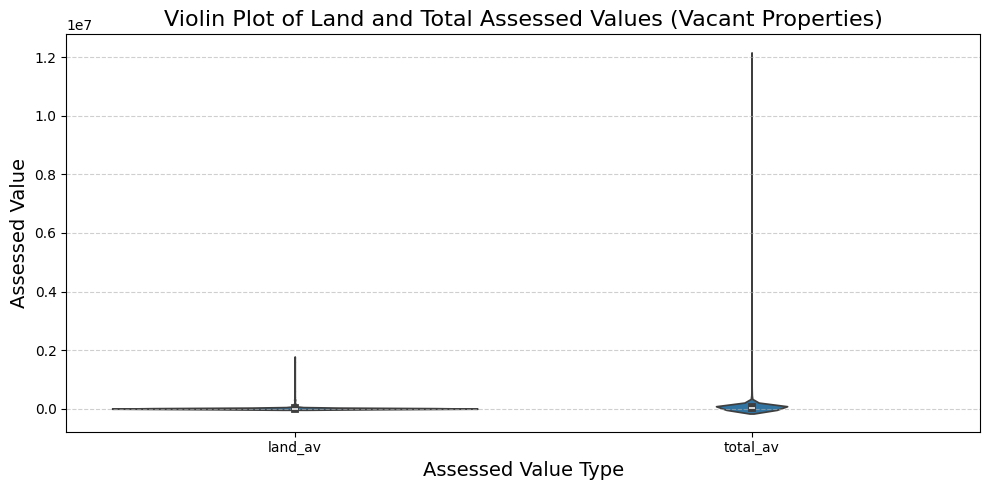

In [36]:
# Assuming final_building_data is your PySpark DataFrame
vacant_data = final_building_data.filter(col("is_vacant") == 1)

# Convert PySpark DataFrame to Pandas DataFrame
vacant_data_pd = vacant_data.select("land_av", "total_av").toPandas()

# Melt the DataFrame for plotting
vacant_data_melted = vacant_data_pd.melt(var_name="Assessed Value Type", value_name="Assessed Value")

# Violin Plot
plt.figure(figsize=(10, 5))
sns.violinplot(data=vacant_data_melted, x="Assessed Value Type", y="Assessed Value")
plt.title("Violin Plot of Land and Total Assessed Values (Vacant Properties)", fontsize=16)
plt.xlabel("Assessed Value Type", fontsize=14)
plt.ylabel("Assessed Value", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [37]:
from pyspark.sql.functions import col, expr

# Calculate Q1 and Q3
quantiles = final_building_data.approxQuantile("total_av", [0.25, 0.75], 0.01)  # Use approxQuantile for efficiency
Q1, Q3 = quantiles
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers in total_av
final_building_data = final_building_data.filter((col("total_av") >= lower_bound) & (col("total_av") <= upper_bound))

<ipython-input-38-dbc5dc52f909>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vacancy_summary = data_pd.groupby("area_bin").agg(


                      area_bin  total_buildings  vacant_buildings
0               (10.0, 20.691]                3                 0
1             (20.691, 42.813]                7                 0
2             (42.813, 88.587]               20                 0
3            (88.587, 183.298]               27                 0
4           (183.298, 379.269]               67                 0
5            (379.269, 784.76]               86                 0
6           (784.76, 1623.777]              314                14
7         (1623.777, 3359.818]             3187               170
8         (3359.818, 6951.928]            22817               815
9        (6951.928, 14384.499]            10665               265
10      (14384.499, 29763.514]             2149                54
11      (29763.514, 61584.821]              864                14
12     (61584.821, 127427.499]              462                 5
13     (127427.499, 263665.09]              235                 3
14     (26

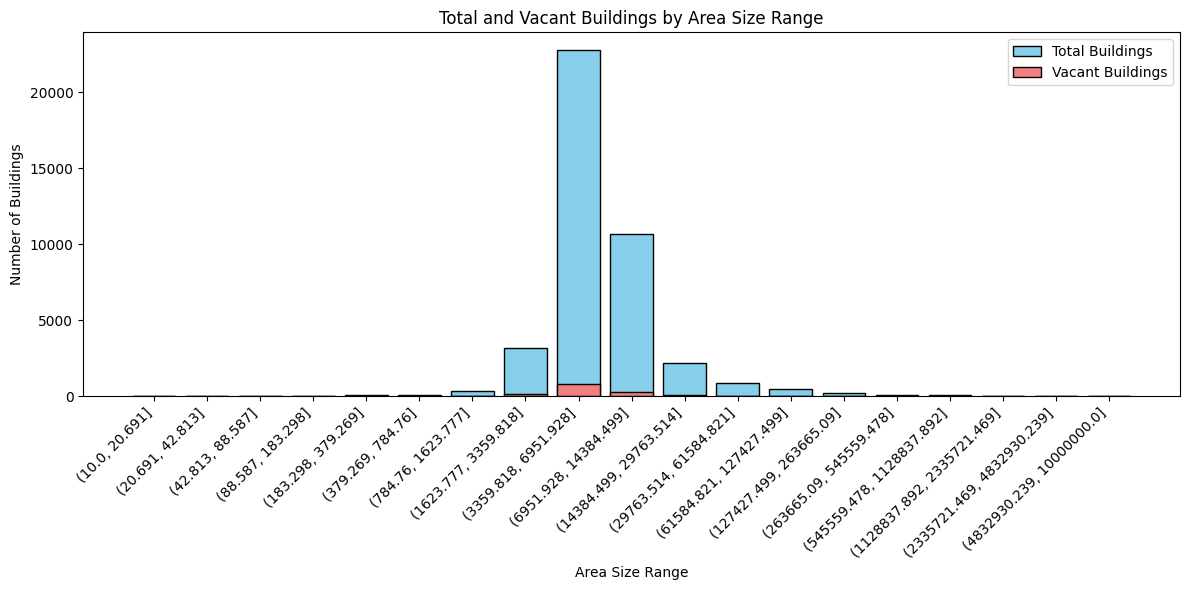

In [38]:
import numpy as np

# Dividing the data into size ranges
data_pd["area_bin"] = pd.cut(data_pd["Shape__Area"], bins=np.logspace(1, 7, 20))

# Calculating the total number of buildings and vacant buildings for each range
vacancy_summary = data_pd.groupby("area_bin").agg(
    total_buildings=("is_vacant", "count"),
    vacant_buildings=("is_vacant", "sum")
).reset_index()

print(vacancy_summary)

plt.figure(figsize=(12, 6))
plt.bar(vacancy_summary["area_bin"].astype(str), vacancy_summary["total_buildings"], label="Total Buildings", color="skyblue", edgecolor="black")
plt.bar(vacancy_summary["area_bin"].astype(str), vacancy_summary["vacant_buildings"], label="Vacant Buildings", color="lightcoral", edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Area Size Range")
plt.ylabel("Number of Buildings")
plt.title("Total and Vacant Buildings by Area Size Range")
plt.legend()
plt.tight_layout()
plt.show()

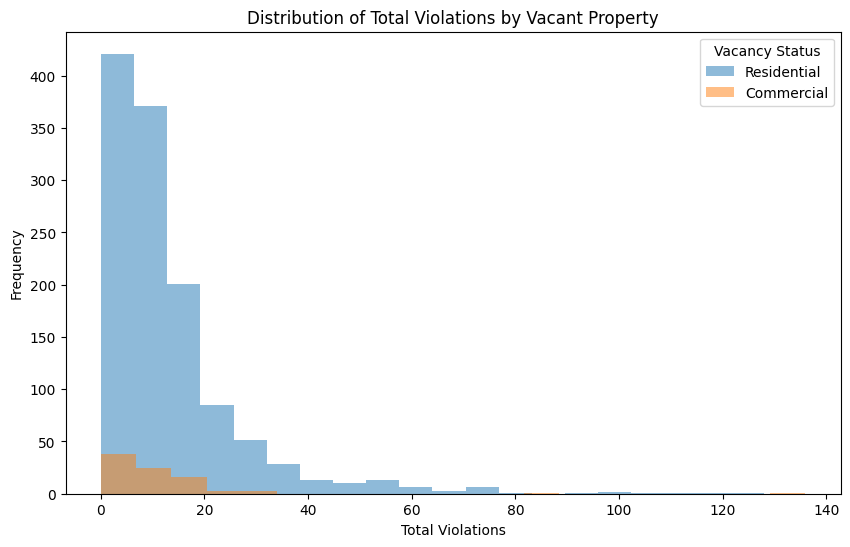

In [39]:
# Relation between violation count and vacant properties
vacant_buildings = final_building_data.filter(col("IPSVacant") != "Not Vacant").toPandas()

plt.figure(figsize=(10, 6))
for status in vacant_buildings["IPSVacant"].unique():
    subset = vacant_buildings[vacant_buildings["IPSVacant"] == status]
    plt.hist(subset["total_violations"], bins=20, alpha=0.5, label=status)

plt.title("Distribution of Total Violations by Vacant Property")
plt.xlabel("Total Violations")
plt.ylabel("Frequency")
plt.legend(title="Vacancy Status")
plt.show()

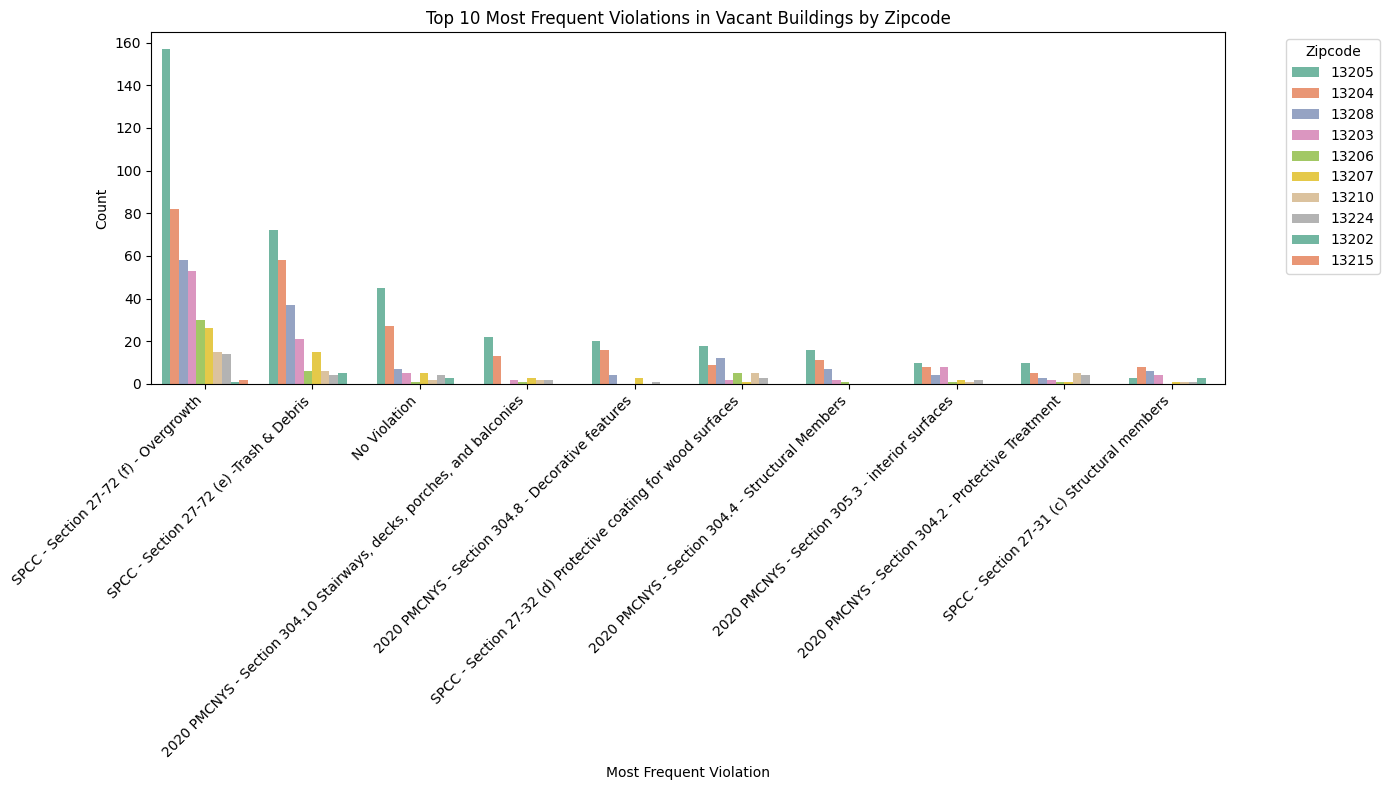

In [40]:
# Filtering Only Vacant Buildings
vacant_buildings = final_building_data.filter(col("IPSVacant") != "Not Vacant")

# Calculating Frequency by most_frequent_violation and zipcode (using 'Zip' instead of 'zipcode')
violation_counts = (
    vacant_buildings.groupBy("most_frequent_violation", "Zip").count().orderBy(col("count").desc()) # Changed 'zipcode' to 'Zip'
    .toPandas()
)

# Selecting Top 10 Violations Across All Zipcodes
top_violations_list = (
    violation_counts.groupby("most_frequent_violation")["count"]
    .sum()
    .nlargest(10)
    .index.tolist()
)

# Filtering for Top 10 Violations
top_violations = violation_counts[violation_counts["most_frequent_violation"].isin(top_violations_list)]

plt.figure(figsize=(14, 8))
sns.barplot(
    data=top_violations,
    x="most_frequent_violation",
    y="count",
    hue="Zip", # Changed 'zipcode' to 'Zip'
    palette="Set2"
)
plt.xlabel("Most Frequent Violation")
plt.ylabel("Count")
plt.title("Top 10 Most Frequent Violations in Vacant Buildings by Zipcode")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Zipcode", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

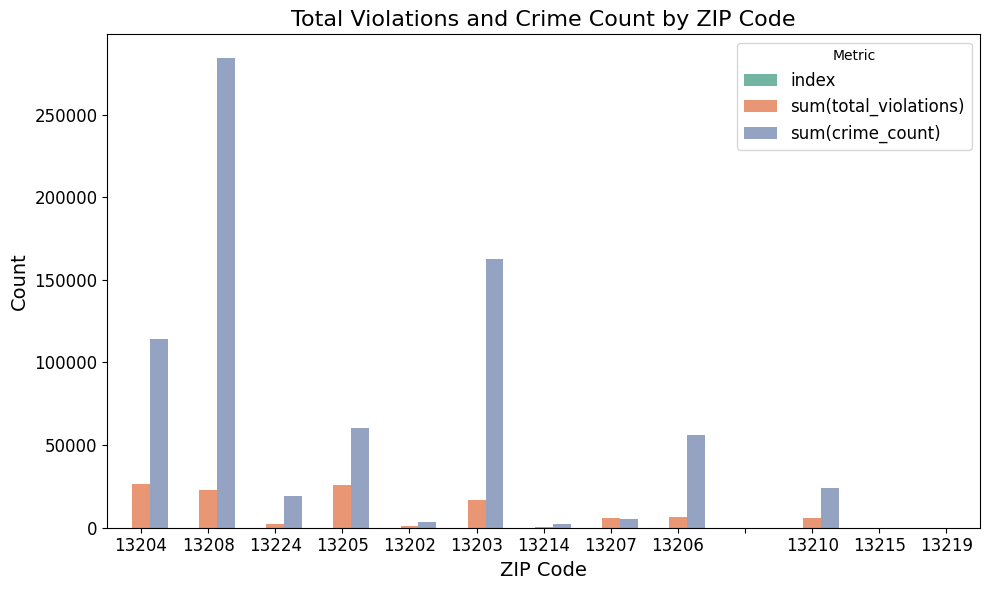

In [42]:
# Group by Zip and calculate the sums
aggregated_data = final_building_data.groupby('Zip').agg({
    'total_violations': 'sum',
    'crime_count': 'sum'
}).toPandas() # Convert to pandas DataFrame before using reset_index

aggregated_data = aggregated_data.reset_index()

melted_data = aggregated_data.melt(id_vars='Zip', var_name='Metric', value_name='Count')

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_data, x='Zip', y='Count', hue='Metric', palette='Set2')

# Add labels and title
plt.title('Total Violations and Crime Count by ZIP Code', fontsize=16)
plt.xlabel('ZIP Code', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Metric', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

<ipython-input-44-e9ed3316b75d>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crime_distribution.index, y=crime_distribution.values, palette='Set3')


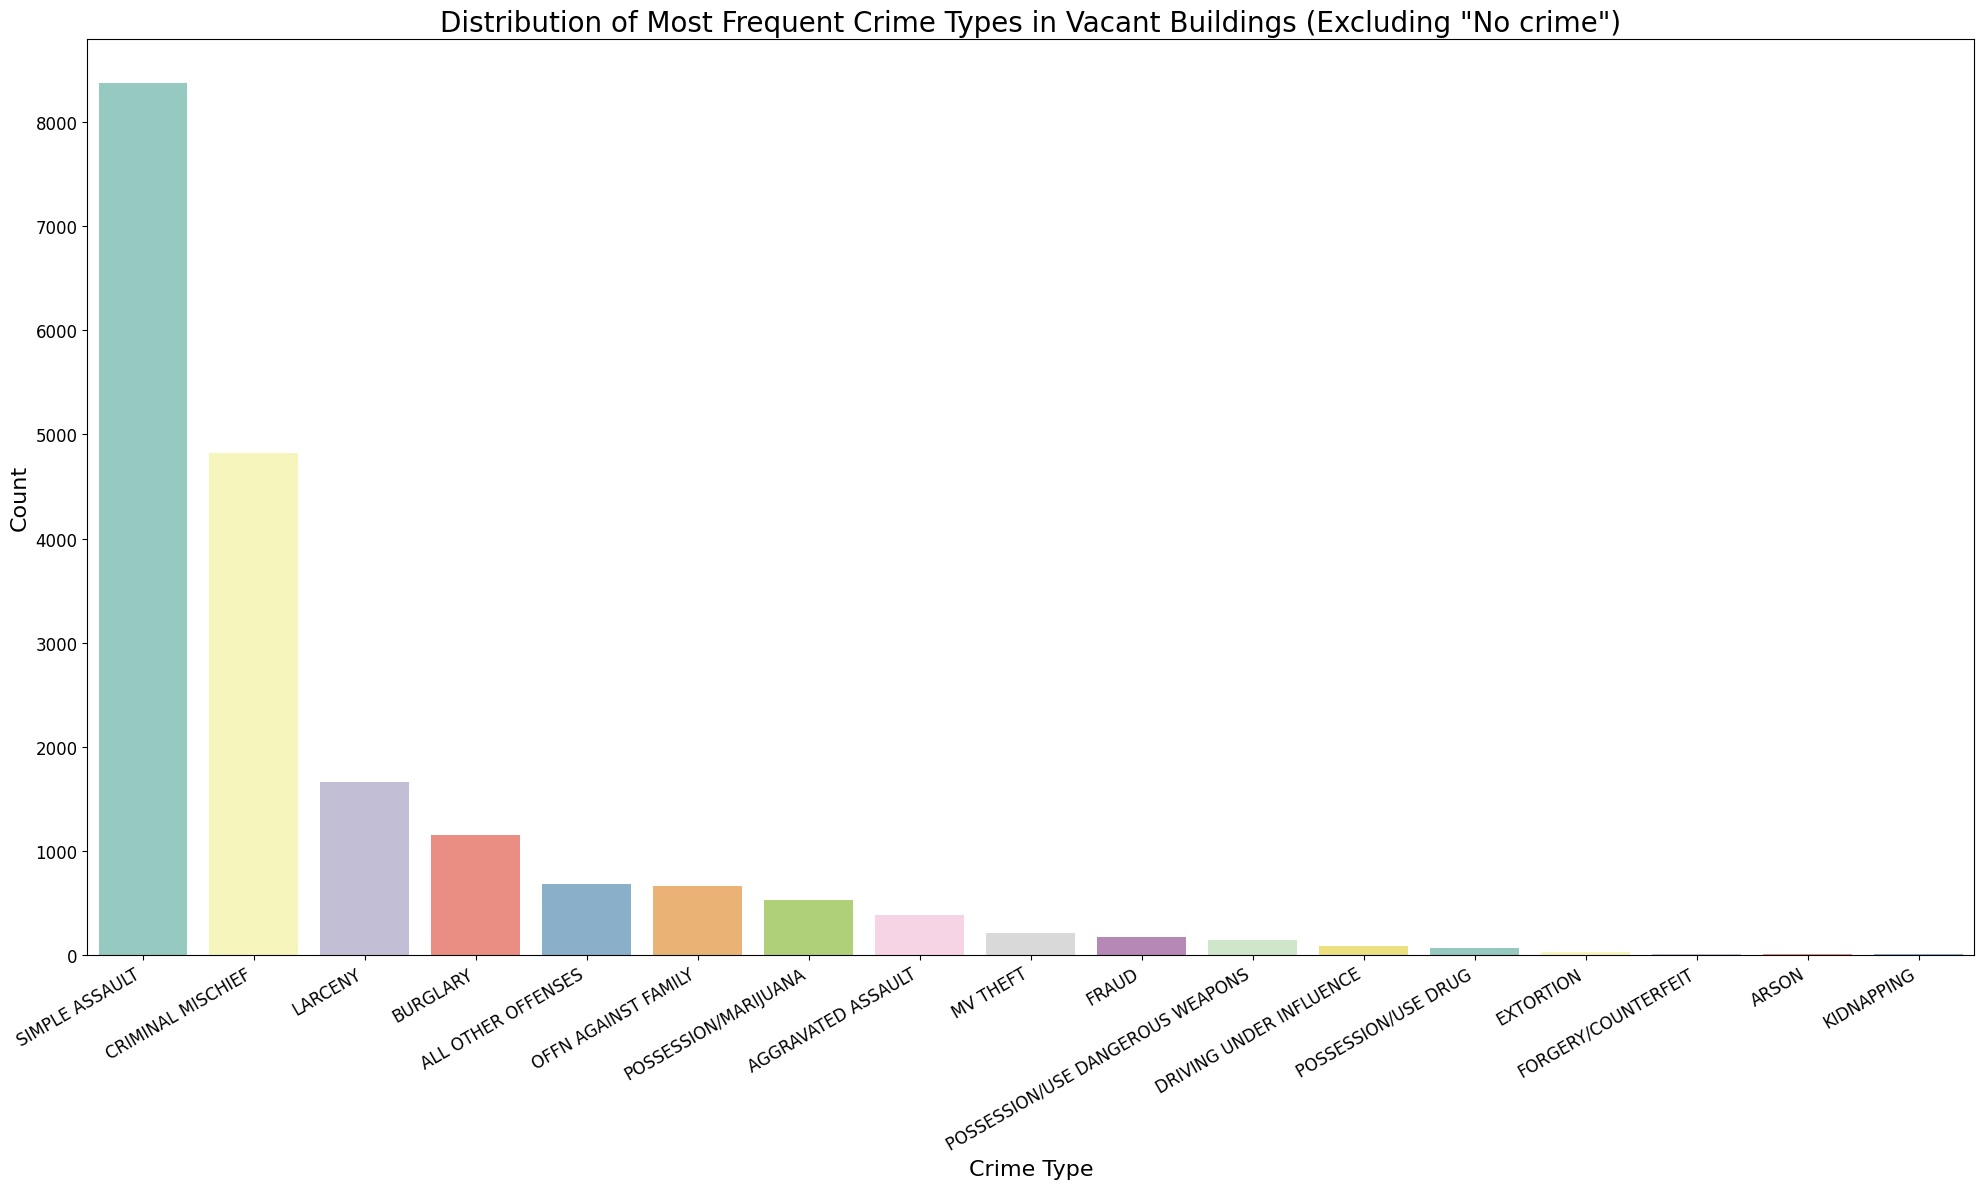

In [44]:
# Filter vacant buildings and exclude 'No crime'
not_vacant_buildings = final_building_data.filter((col("IPSVacant") == "Not Vacant") & (col("most_frequent_crime") != "No crime"))

# Ensure 'most_frequent_crime' column exists and has multiple entries
if 'most_frequent_crime' in not_vacant_buildings.columns:
    # Count occurrences of each crime type
    # Using groupBy and count to get the frequency of each crime type
    crime_distribution = not_vacant_buildings.groupBy('most_frequent_crime').count().toPandas()
    crime_distribution = crime_distribution.set_index('most_frequent_crime')['count']  # Convert to Series for plotting

    # Sort the values in ascending order
    crime_distribution = crime_distribution.sort_values(ascending=False)

    plt.figure(figsize=(20, 12))  # Increase figure size for better spacing
    sns.barplot(x=crime_distribution.index, y=crime_distribution.values, palette='Set3')

    # Customize the plot
    plt.title('Distribution of Most Frequent Crime Types in Vacant Buildings (Excluding "No crime")', fontsize=20)
    plt.xlabel('Crime Type', fontsize=16)
    plt.ylabel('Count', fontsize=16)

    # Rotate and align x-axis labels
    plt.xticks(rotation=30, ha='right', fontsize=12)  # Rotate 30 degrees and align to the right
    plt.yticks(fontsize=12)

    # Add tight layout for better spacing
    plt.tight_layout()
    plt.show()


<ipython-input-45-8a1085c2b553>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crime_distribution.index, y=crime_distribution.values, palette='Set3')


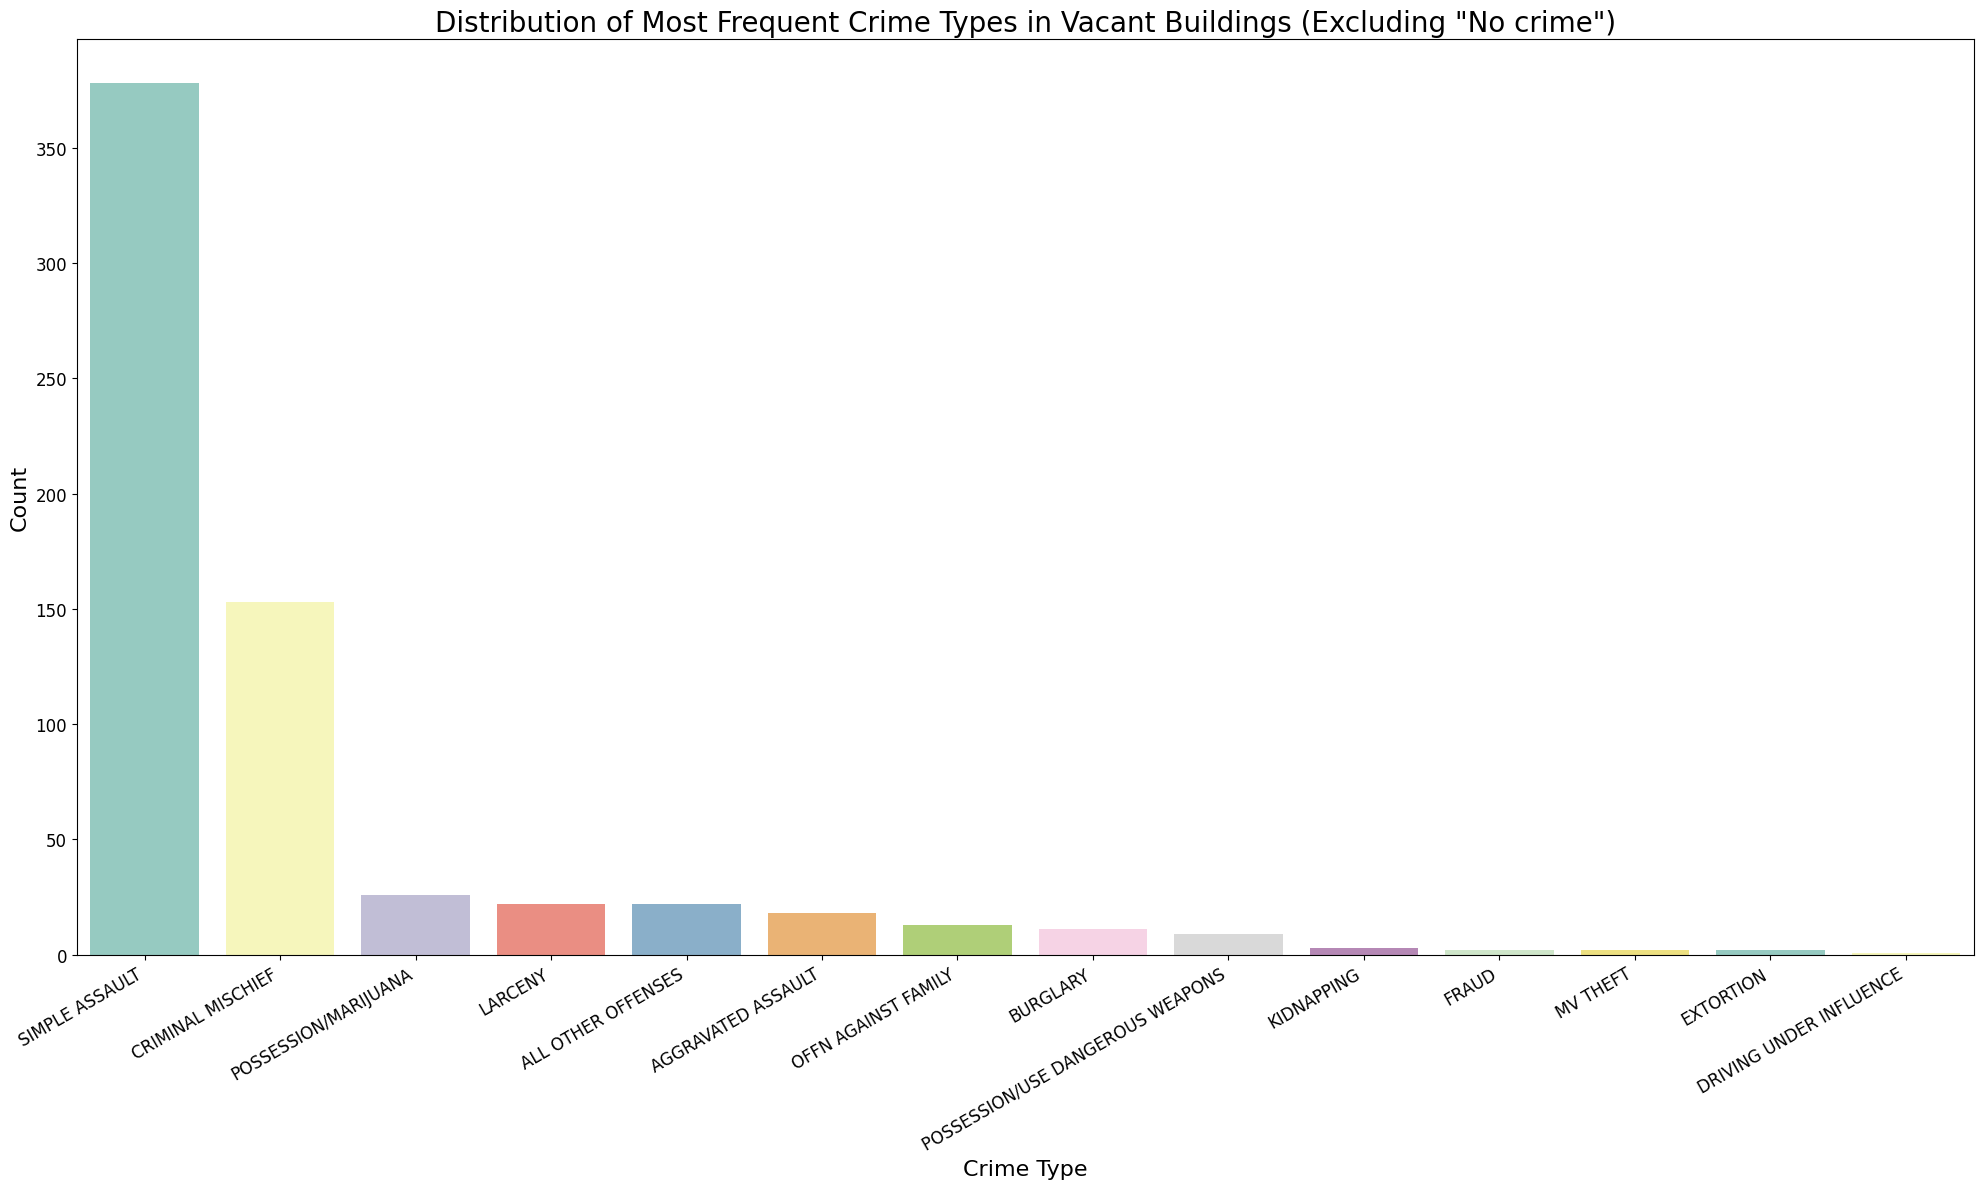

In [45]:
# Filter vacant buildings and exclude 'No crime'
vacant_buildings = final_building_data.filter((col("IPSVacant") != "Not Vacant") & (col("most_frequent_crime") != "No crime"))

# Ensure 'most_frequent_crime' column exists and has multiple entries
if 'most_frequent_crime' in vacant_buildings.columns:
    # Count occurrences of each crime type
    # Using groupBy and count to get the frequency of each crime type
    crime_distribution = vacant_buildings.groupBy('most_frequent_crime').count().toPandas()
    crime_distribution = crime_distribution.set_index('most_frequent_crime')['count']  # Convert to Series for plotting

    # Sort the values in ascending order
    crime_distribution = crime_distribution.sort_values(ascending=False)

    plt.figure(figsize=(20, 12))  # Increase figure size for better spacing
    sns.barplot(x=crime_distribution.index, y=crime_distribution.values, palette='Set3')

    # Customize the plot
    plt.title('Distribution of Most Frequent Crime Types in Vacant Buildings (Excluding "No crime")', fontsize=20)
    plt.xlabel('Crime Type', fontsize=16)
    plt.ylabel('Count', fontsize=16)

    # Rotate and align x-axis labels
    plt.xticks(rotation=30, ha='right', fontsize=12)  # Rotate 30 degrees and align to the right
    plt.yticks(fontsize=12)

    # Add tight layout for better spacing
    plt.tight_layout()
    plt.show()

<ipython-input-46-dfc9659cfa71>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="ZIP Code Type", y="Vacant Building Count", data=distribution, palette="Set3", edgecolor="black")


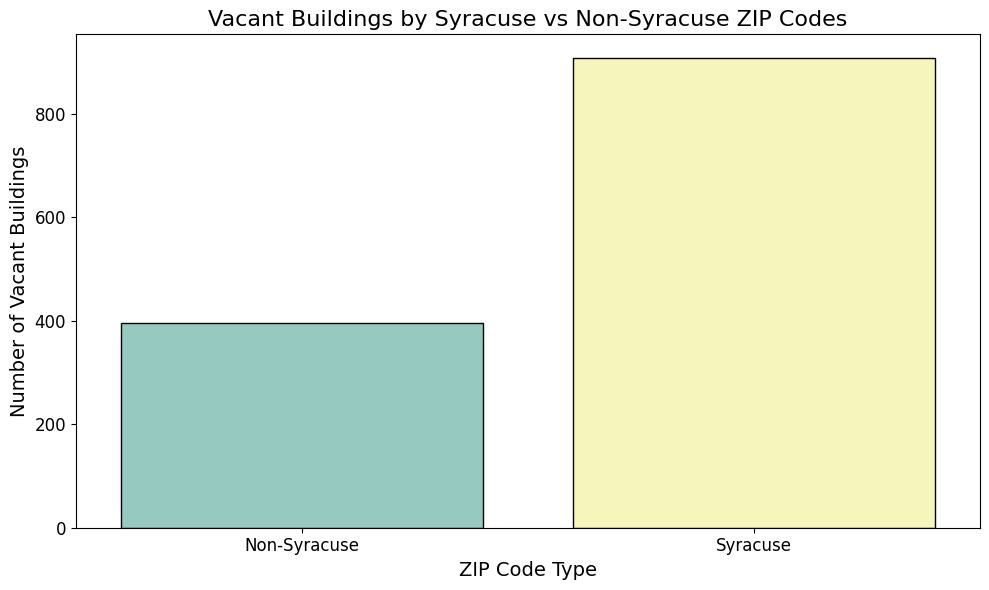

In [46]:
# Syracuse ZIP codes
syracuse_zipcodes = ["13219", "13215", "13204", "13207", "13202", "13205", "13208", "13203", "13210", "13206", "13224", "13214"]

# Add a column indicating whether owner_zipcode is in Syracuse
final_building_data = final_building_data.withColumn(
    "is_syracuse_zip",
    when(col("owner_zipcode").isin(syracuse_zipcodes), "Syracuse").otherwise("Non-Syracuse")
)

# Filter for only vacant buildings
vacant_buildings = final_building_data.filter(col("is_vacant") == 1)

# Calculate vacancy distribution based on ZIP code type
distribution = vacant_buildings.groupBy("is_syracuse_zip").count().toPandas()

distribution.columns = ["ZIP Code Type", "Vacant Building Count"]

# Plotting vacancy distribution by ZIP code type
plt.figure(figsize=(10, 6))
sns.barplot(x="ZIP Code Type", y="Vacant Building Count", data=distribution, palette="Set3", edgecolor="black")

plt.title("Vacant Buildings by Syracuse vs Non-Syracuse ZIP Codes", fontsize=16)
plt.xlabel("ZIP Code Type", fontsize=14)
plt.ylabel("Number of Vacant Buildings", fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



# Feature Engineering
Feature engineering involves creating new variables or modifying existing ones to improve model performance. Based on EDA, we focus on the following key transformations to better capture patterns related to property vacancies:

- **Create a new variable for the "West" region**: To capture regional differences in property vacancies, we create a binary variable (`west_region`) that indicates whether a property is located in the western part of Syracuse.

- **Engineer a flag for overgrowth violations**: We create a new feature (`overgrowth_violation`) to flag properties with overgrowth violations. This variable was created because **overgrowth violations are frequently observed in vacant properties**. This suggests that properties with overgrowth violations may be neglected, which could be correlated with higher vacancy rates. Including this flag helps the model capture the relationship between neglect and vacancy.
- **Crime and Violation Data Transformation**: In the earlier stages, we engineered new features from the **crime** and **code violation data**, such as the most frequent crime types and violations. These features help provide additional context for understanding which factors influence vacancy rates.


By transforming the data in these ways, we aim to improve the model’s ability to predict property vacancies and capture meaningful patterns that may influence vacancy rates.

In [47]:
# add new variable wheather it is overgrowth or not
from pyspark.sql.functions import when, col

# SPCC - Section 27-72 (f) - Overgrowth
final_building_data = final_building_data.withColumn(
    "overgrowth_violation",
    when(col("most_frequent_violation") == "SPCC - Section 27-72 (f) - Overgrowth", 1).otherwise(0)
)


final_building_data.groupBy("overgrowth_violation").count().show()

+--------------------+-----+
|overgrowth_violation|count|
+--------------------+-----+
|                   1| 3595|
|                   0|34240|
+--------------------+-----+



In [48]:
# wheather DPW_Quad is Northwest or Southwest
final_building_data = final_building_data.withColumn(
    "Quad_Region",
    when(col("DPW_Quad").isin("NORTHWEST", "SOUTHWEST"), "West").otherwise("Other")
)


# Data Preprocessing
In this section, we perform several steps to prepare the data for modeling. These steps include:

- **Handling outliers**: After identifying that the `total_av` variable had outliers, we decided to remove them. Given that there was insufficient vacant data, we focused on removing outliers from the non-vacant data to prevent bias in the model.

- **Data selection for modeling**: We selected the relevant features and variables to be used for modeling. This step ensures that the dataset contains all necessary information for prediction while excluding irrelevant or redundant columns.

- **Handling categorical variables**: We use **StringIndexer** to convert categorical variables into numeric format. This allows the machine learning model to process these variables. Additionally, **OneHotEncoder** is used to create binary features for each category, which helps the model capture the relationship between categorical variables and the target variable.

- **Vectorization**: After preprocessing the categorical data, we used **VectorAssembler** to combine all the features into a single vector column. This step is required for most machine learning algorithms to process multiple features efficiently.

- **Scaling continuous variables**: Finally, we applied **StandardScaler** to continuous variables like property value and lot size to ensure they are on the same scale, preventing any single feature from dominating the model's learning process.

- **Handling class imbalance**: Since the data was imbalanced, we performed **data augmentation** by oversampling the vacant properties. We sampled a subset of the vacant property data and combined it with the non-vacant data, ensuring a more balanced dataset for modeling. This helps to prevent bias towards the majority class during training.

- **PCA (Principal Component Analysis)**: To reduce the dimensionality of the dataset and improve model performance, we applied **PCA**. This technique allowed us to transform the features into a smaller set of principal components, capturing the most important patterns in the data and reducing noise.

By completing these preprocessing steps, the data is now ready for modeling, with clean and well-prepared features that will improve the model's ability to make accurate predictions.


In [49]:
from pyspark.sql.functions import col, expr

# Calculate Q1 and Q3
quantiles = final_building_data.approxQuantile("total_av", [0.25, 0.75], 0.01)  # Use approxQuantile for efficiency
Q1, Q3 = quantiles
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers in total_av
final_building_data = final_building_data.filter((col("total_av") >= lower_bound) & (col("total_av") <= upper_bound))

In [ ]:
final_building_data.show(5)

+-----+----------+----------+------------+-------+--------+-----+-----+-----+--------+---------+---------+----+----------+---+----------------+----------------+----------+----------------------+------------+----------------+-----------------------+-----------+-------------------+---------+-------------+---------------+--------------------+-----------+
|  Zip|n_ResUnits|LUC_parcel|   LU_parcel|land_av|total_av|ACRES|FRONT|DEPTH|yr_built| DPW_Quad|    NHOOD|InPD|ELECT_DIST|RNI|     Shape__Area|   Shape__Length| IPSVacant|building_clean_address|Neighborhood|total_violations|most_frequent_violation|crime_count|most_frequent_crime|is_vacant|owner_zipcode|is_syracuse_zip|overgrowth_violation|Quad_Region|
+-----+----------+----------+------------+-------+--------+-----+-----+-----+--------+---------+---------+----+----------+---+----------------+----------------+----------+----------------------+------------+----------------+-----------------------+-----------+-------------------+---------+--

In [50]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Processing Categorical Columns: StringIndexer and OneHotEncoder
#categorical_cols = ["Zip", "LU_parcel", "DPW_Quad", "NHOOD", "ELECT_DIST", "most_frequent_violation", "owner_zipcode",'overgrowth_violation']
categorical_cols = ["Zip", "Quad_Region", "ELECT_DIST",'overgrowth_violation']
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_vec") for col in categorical_cols]

for col_name in categorical_cols:
    final_building_data = final_building_data.withColumn(
        col_name,
        when(col(col_name) == "", "Unknown").otherwise(col(col_name))
    )

# Processing Numerical Columns
# numeric_cols = ["land_av", "total_av","Shape__Area", "total_violations", "n_ResUnits"]
numeric_cols = ["land_av", "total_av","Shape__Area", "total_violations", "n_ResUnits"]

# Combining All Features into a Single Vector
assembler = VectorAssembler(
    inputCols=[f"{col}_vec" for col in categorical_cols] + numeric_cols,
    outputCol="features"
)

# Build Pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Conduct pipeline
processed_data = pipeline.fit(final_building_data).transform(final_building_data)


processed_data.select("features", "is_vacant").show(truncate=False)

+------------------------------------------------------------------------------------------+---------+
|features                                                                                  |is_vacant|
+------------------------------------------------------------------------------------------+---------+
|(37,[2,12,14,31,32,33,34],[1.0,1.0,1.0,1.0,10000.0,10000.0,12874.6703491211])             |0        |
|(37,[2,12,14,31,32,33,34],[1.0,1.0,1.0,1.0,1500.0,1500.0,599.148254394531])               |0        |
|(37,[2,12,14,31,32,33,34],[1.0,1.0,1.0,1.0,77000.0,120000.0,14163.094909668])             |0        |
|(37,[2,12,14,31,32,33,34],[1.0,1.0,1.0,1.0,57500.0,87300.0,8183.52423095703])             |0        |
|(37,[2,12,14,31,32,33,34],[1.0,1.0,1.0,1.0,13300.0,13300.0,12509.2610473633])             |0        |
|(37,[2,12,14,31,32,33,34,35],[1.0,1.0,1.0,1.0,6100.0,6100.0,3130.13214111328,2.0])        |0        |
|(37,[2,12,14,31,32,33,34,35,36],[1.0,1.0,1.0,1.0,6000.0,38300.0,3092.495

In [51]:
# handling inbalanced data

# Separating Vacant and Non-Vacant Data
vacant_data = processed_data.filter(col("is_vacant") == 1)
non_vacant_data = processed_data.filter(col("is_vacant") == 0)

# Sampling a Subset of Non-Vacant Data
oversampled_vacant_property = vacant_data.sample(withReplacement=True, fraction=3.0, seed=42)

# Combining Sampled Data with Vacant Data
balanced_data = non_vacant_data.union(oversampled_vacant_property)

In [52]:
from pyspark.ml.feature import StandardScaler

# scale data
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
balanced_data_scaled = scaler.fit(balanced_data).transform(balanced_data)

In [53]:
from pyspark.ml.feature import PCA

# Apply PCA
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(balanced_data_scaled)
pca_data = pca_model.transform(balanced_data_scaled)

# Modeling

In this section, we performed clustering and regression to predict property vacancies, focusing on the following steps:

- **Clustering with KMeans and GMM**: We applied **KMeans** and **Gaussian Mixture Models (GMM)** to cluster the data. KMeans performed better in this case, revealing distinct patterns in the data based on features like property value and location.

- **Cluster Analysis**: We analyzed the clusters obtained from **KMeans** to identify patterns in vacant and non-vacant properties. This helped us understand which features (e.g., property value, neighborhood) were most influential in determining vacancy likelihood.

- **Regression with Random Forest and Logistic Regression**: To predict vacancy, we used **Random Forest** and **Logistic Regression**. **Random Forest** outperformed Logistic Regression, showing higher accuracy and robustness in handling complex feature interactions.

- **Identifying High Vacancy Properties**: Finally, we used the trained **Random Forest** model to identify properties with the highest probability of being vacant, and extracted the corresponding addresses, which could be targeted for further investigation.

These steps provide a comprehensive approach to predicting property vacancies, leveraging both clustering and regression techniques to uncover valuable insights.


K-menas

In [54]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


kmeans = KMeans(featuresCol="pca_features", k=2,  seed=42)
kmeans_model = kmeans.fit(pca_data)
kmean_clustered_data = kmeans_model.transform(pca_data)

evaluator = ClusteringEvaluator(featuresCol="pca_features")
silhouette = evaluator.evaluate(kmean_clustered_data)
print(f"Silhouette Score after PCA: {silhouette}")

Silhouette Score after PCA: 0.6020368975387552


In [55]:
#checking my cluster
kmean_cluster = kmean_clustered_data.groupBy("prediction", "is_vacant").count().orderBy("prediction", "is_vacant")
kmean_cluster.show()

+----------+---------+-----+
|prediction|is_vacant|count|
+----------+---------+-----+
|         0|        0|20921|
|         0|        1| 3183|
|         1|        0|14880|
|         1|        1|  669|
+----------+---------+-----+



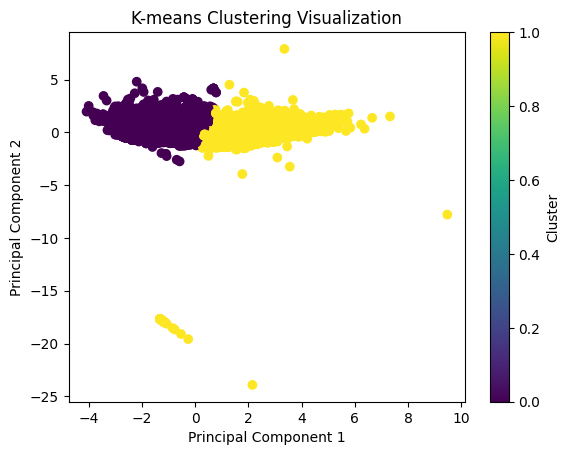

In [56]:
#kmean cluster visualization
pca_df = kmean_clustered_data.select("pca_features", "prediction").toPandas()
pca_features = np.array(pca_df["pca_features"].tolist())

plt.scatter(pca_features[:, 0], pca_features[:, 1], c=pca_df["prediction"], cmap="viridis")
plt.title("K-means Clustering Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

In [57]:
#cluster avg info
kmean_clustered_data.groupBy("prediction").agg(
    {"total_av": "avg", "land_av":"avg","total_violations": "avg", "n_ResUnits": "avg", "Shape__Area": "avg" }
).show()

+----------+-----------------+------------------+---------------------+------------------+-----------------+
|prediction| avg(Shape__Area)|   avg(n_ResUnits)|avg(total_violations)|      avg(land_av)|    avg(total_av)|
+----------+-----------------+------------------+---------------------+------------------+-----------------+
|         1|9542.020967603612| 1.138658434626021|    1.411666345102579|15828.956395909705| 87548.0531223873|
|         0|6489.230141225385|1.2151095253899769|    5.004770992366412| 9055.596581480253|51629.95212412877|
+----------+-----------------+------------------+---------------------+------------------+-----------------+



Gaussian Mixture Models


In [58]:
from pyspark.ml.clustering import GaussianMixture

# Gaussian Mixture Model
gmm = GaussianMixture(featuresCol="pca_features", k=2, seed=42)
gmm_model = gmm.fit(pca_data)

# Predict Clusters
clustered_data_gmm = gmm_model.transform(pca_data)

# Evaluate Clustering
evaluator = ClusteringEvaluator(featuresCol="pca_features", predictionCol="prediction", metricName="silhouette")
silhouette_gmm = evaluator.evaluate(clustered_data_gmm)
print(f"Silhouette Score with GMM: {silhouette_gmm}")


Silhouette Score with GMM: 0.9621108893720712


In [59]:
#checking gmm cluster
cluster_vs_vacancy = clustered_data_gmm.groupBy("prediction", "is_vacant").count().orderBy("prediction", "is_vacant")
cluster_vs_vacancy.show()

+----------+---------+-----+
|prediction|is_vacant|count|
+----------+---------+-----+
|         0|        0|35465|
|         0|        1| 3821|
|         1|        0|  336|
|         1|        1|   31|
+----------+---------+-----+



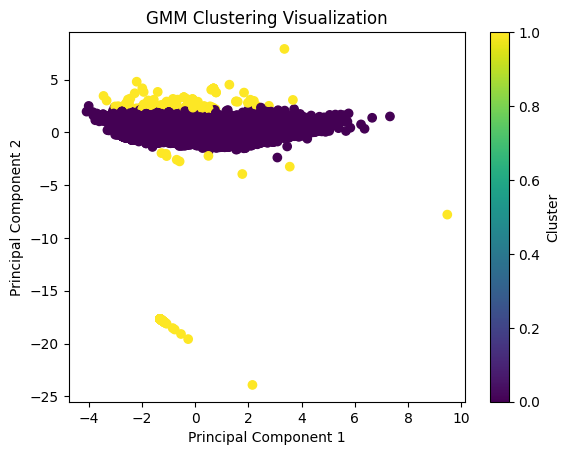

In [60]:
#gmm cluster visulaization
pca_df = clustered_data_gmm.select("pca_features", "prediction").toPandas()
pca_features = np.array(pca_df["pca_features"].tolist())

plt.scatter(pca_features[:, 0], pca_features[:, 1], c=pca_df["prediction"], cmap="viridis")
plt.title("GMM Clustering Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

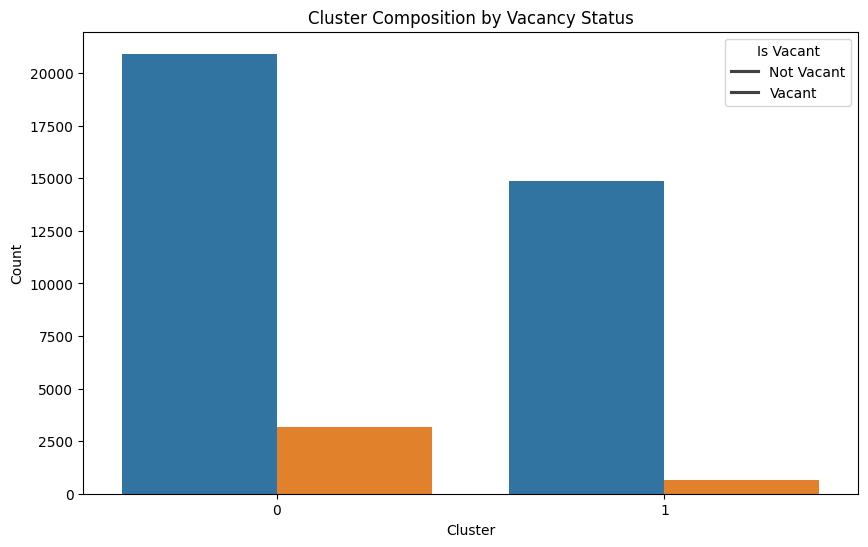

In [61]:
# Visualization of the composition by cluster
cluster_composition_pd = kmean_cluster.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_composition_pd, x="prediction", y="count", hue="is_vacant")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Cluster Composition by Vacancy Status")
plt.legend(title="Is Vacant", labels=["Not Vacant", "Vacant"])
plt.show()

In [62]:
# Calculating the average of key characteristics by cluster
cluster_summary = kmean_clustered_data.groupBy("prediction").agg(
    {"n_ResUnits": "avg", "land_av": "avg", "total_violations": "avg", "total_av" : "avg","Shape__Area": "avg" }
)
cluster_summary.show()

+----------+-----------------+------------------+---------------------+------------------+-----------------+
|prediction| avg(Shape__Area)|   avg(n_ResUnits)|avg(total_violations)|      avg(land_av)|    avg(total_av)|
+----------+-----------------+------------------+---------------------+------------------+-----------------+
|         1|9542.020967603612| 1.138658434626021|    1.411666345102579|15828.956395909705| 87548.0531223873|
|         0|6489.230141225385|1.2151095253899769|    5.004770992366412| 9055.596581480253|51629.95212412877|
+----------+-----------------+------------------+---------------------+------------------+-----------------+



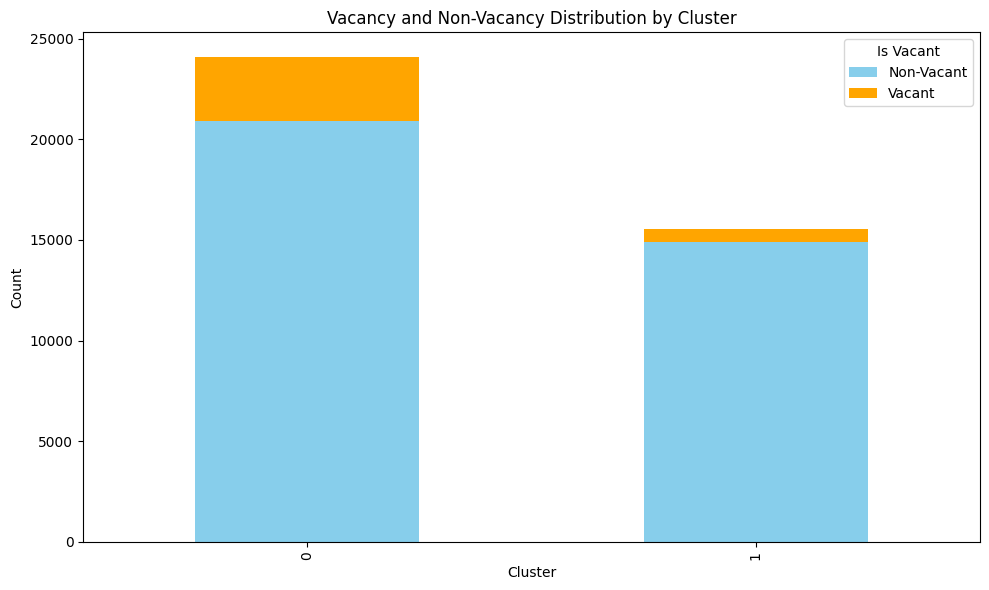

In [63]:
mapping_pd = kmean_cluster.toPandas()

# kmean - visualization of the ratio of vacant to non-vacant properties
pivot_data = mapping_pd.pivot(index="prediction", columns="is_vacant", values="count").fillna(0)
pivot_data.plot(kind="bar", stacked=True, figsize=(10, 6), color=["skyblue", "orange"])

plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Vacancy and Non-Vacancy Distribution by Cluster")
plt.legend(title="Is Vacant", labels=["Non-Vacant", "Vacant"])
plt.tight_layout()
plt.show()

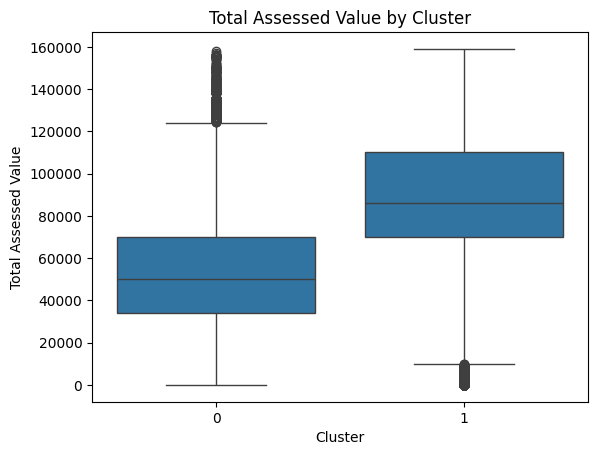

In [64]:
#total value difference
sns.boxplot(x="prediction", y="total_av", data=kmean_clustered_data.toPandas())
plt.title("Total Assessed Value by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Total Assessed Value")
plt.show()

Random Forest Regression

In [65]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Train-Test Split before scaling
train_data, test_data = balanced_data.randomSplit([0.7, 0.3], seed=42)

# Data Scaling
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(train_data)
train_data_scaled = scaler_model.transform(train_data)
test_data_scaled = scaler_model.transform(test_data)

# Add Class Weights to Train Data
final_vacant_count = train_data_scaled.filter(col("is_vacant") == 1).count()
final_non_vacant_count = train_data_scaled.filter(col("is_vacant") == 0).count()

train_data_weighted = train_data_scaled.withColumn(
    "class_weight",
    when(col("is_vacant") == 1, final_non_vacant_count / final_vacant_count).otherwise(1)
)

# Apply PCA for Dimensionality Reduction
pca = PCA(k=5, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(train_data_weighted)
train_data_pca = pca_model.transform(train_data_weighted)
test_data_pca = pca_model.transform(test_data_scaled)

In [66]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# Random Forest Model
rf = RandomForestClassifier(
    featuresCol="pca_features",
    labelCol="is_vacant",
    weightCol="class_weight",
    predictionCol="prediction",
    numTrees=50,
    maxDepth=10
)

# Hyperparameter Tuning with Cross Validation
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50]) \
    .addGrid(rf.maxDepth, [10]) \
    .build()

crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=param_grid,
    evaluator=BinaryClassificationEvaluator(labelCol="is_vacant", metricName="areaUnderROC"),
    numFolds=3
)

# Train Model with Cross Validation
cv_model = crossval.fit(train_data_pca)

# Predict on Test Data
test_predictions = cv_model.transform(test_data_pca)

# Evaluate Performance
evaluator = BinaryClassificationEvaluator(labelCol="is_vacant", metricName="areaUnderROC")
auc = evaluator.evaluate(test_predictions)
print(f"Test AUC: {auc:.2f}")

# Precision, Recall, F1-Score
tp = test_predictions.filter((col("is_vacant") == 1) & (col("prediction") == 1)).count()
fp = test_predictions.filter((col("is_vacant") == 0) & (col("prediction") == 1)).count()
fn = test_predictions.filter((col("is_vacant") == 1) & (col("prediction") == 0)).count()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")

Test AUC: 0.92
Precision: 0.41
Recall: 0.78
F1-Score: 0.54


In [68]:
evaluator_pr = BinaryClassificationEvaluator(labelCol="is_vacant", metricName="areaUnderPR")
pr_auc = evaluator_pr.evaluate(test_predictions)
print(f"Precision-Recall AUC: {pr_auc:.2f}")

Precision-Recall AUC: 0.59


In [69]:
test_predictions.groupBy("is_vacant", "prediction").count().show()

+---------+----------+-----+
|is_vacant|prediction|count|
+---------+----------+-----+
|        0|       0.0| 9377|
|        0|       1.0| 1228|
|        1|       0.0|  241|
|        1|       1.0|  855|
+---------+----------+-----+



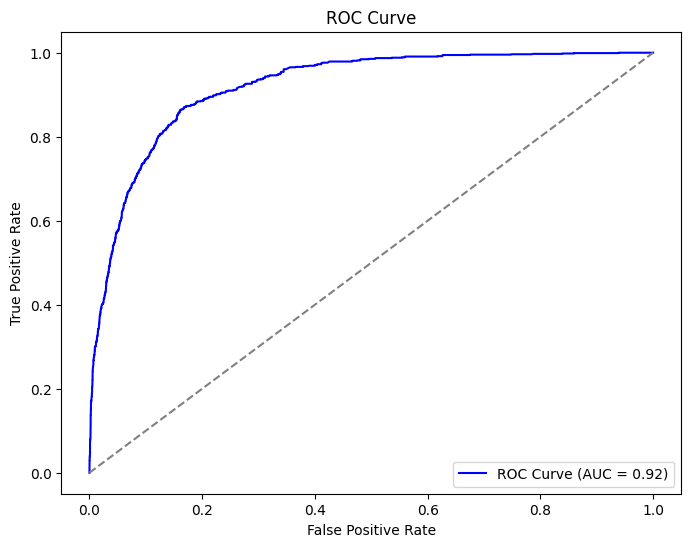

In [70]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.functions import vector_to_array

# Probability
test_predictions = test_predictions.withColumn("probability_array", vector_to_array("probability"))
test_predictions = test_predictions.withColumn("prob_positive", expr("probability_array[1]"))

# Collect
true_labels = test_predictions.select("is_vacant").rdd.flatMap(lambda x: x).collect()
pred_probs = test_predictions.select("prob_positive").rdd.flatMap(lambda x: x).collect()

# creat ROC Curve for visualization
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Logistic Regression

In [71]:
from pyspark.ml.classification import LogisticRegression

# Logistic Regression Model
lr = LogisticRegression(
    featuresCol="pca_features",
    labelCol="is_vacant",
    weightCol="class_weight",
    predictionCol="prediction",
    maxIter=100,
    regParam=0.01
)

# Train the Logistic Regression Model
lr_model = lr.fit(train_data_pca)

#  Make Predictions on Test Data
test_predictions = lr_model.transform(test_data_pca)

# Evaluate Model Performance
evaluator = BinaryClassificationEvaluator(labelCol="is_vacant", metricName="areaUnderROC")
auc = evaluator.evaluate(test_predictions)
print(f"Test AUC: {auc:.2f}")

# Calculate Precision, Recall, and F1-Score
tp = test_predictions.filter((col("is_vacant") == 1) & (col("prediction") == 1)).count()
fp = test_predictions.filter((col("is_vacant") == 0) & (col("prediction") == 1)).count()
fn = test_predictions.filter((col("is_vacant") == 1) & (col("prediction") == 0)).count()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")

#Randonforest shows better performance for our project

Test AUC: 0.74
Precision: 0.17
Recall: 0.69
F1-Score: 0.28


Predicting future vacant properties from non-vacant data using Random Forest

In [72]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(non_vacant_data)  # `vacant_data`is already vector
non_vacant_data_scaled = scaler_model.transform(non_vacant_data)

# Apply PCA on the non-vacant data
non_vacant_data_pca = pca_model.transform(non_vacant_data_scaled)  # Apply PCA to non-vacant data

# Predict on non-vacant properties
non_vacant_predictions = cv_model.transform(non_vacant_data_pca)

# Extract the vacant probability (model's probability output for class 1, which is vacant)
extract_probability_udf = udf(lambda v: float(v[1]), DoubleType())

# Extract vacant probability for non-vacant properties
non_vacant_predictions = non_vacant_predictions.withColumn(
    "vacant_probability",
    extract_probability_udf(col("probability"))
)

# Filter non-vacant properties with high vacancy probability
likely_to_be_vacant = non_vacant_predictions.filter(col("vacant_probability") > 0.5)

# Show the results
likely_to_be_vacant.select("building_clean_address", "vacant_probability") \
    .orderBy(col("vacant_probability").desc()) \
    .show(10, truncate=False)


+----------------------+------------------+
|building_clean_address|vacant_probability|
+----------------------+------------------+
|175 FOREST AVE        |0.9576004052238868|
|615 CATHERINE ST      |0.9501671680573778|
|522-24 DELAWARE ST    |0.9484465978019576|
|102 HERRIMAN ST       |0.9484465978019576|
|205 BARRETT ST        |0.9484465978019576|
|207 HERRIMAN ST       |0.9484465978019576|
|127 COOLIDGE AVE      |0.9484465978019576|
|350 RICHMOND AVE      |0.9484465978019576|
|443 SHONNARD ST       |0.9473690671869751|
|302 MERRIMAN AVE      |0.9473690671869751|
+----------------------+------------------+
only showing top 10 rows



# Conclusion

We performed clustering and regression to predict property vacancies, focusing on the following steps:

- **Clustering with KMeans and GMM**: We applied **KMeans** and **Gaussian Mixture Models (GMM)** to cluster the data. KMeans performed better in this case, revealing distinct patterns in the data based on features like property value and location.

- **Cluster Analysis**: We analyzed the clusters obtained from **KMeans** to identify patterns in vacant and non-vacant properties. This helped us understand which features were most influential in determining vacancy likelihood.

- **Regression with Random Forest and Logistic Regression**: To predict vacancy, we used **Random Forest** and **Logistic Regression**. **Random Forest** outperformed Logistic Regression, showing higher accuracy and robustness in handling complex feature interactions.

- **Identifying High Vacancy Properties**: Finally, we used the trained **Random Forest** model to identify properties with the highest probability of being vacant, and extracted the corresponding addresses, which could be targeted for further investigation.

These steps provide a comprehensive approach to predicting property vacancies, leveraging both clustering and regression techniques to uncover valuable insights.
